<a href="https://colab.research.google.com/github/omkarmohite123/Project-Novozymes-Enzyme-Stability-Prediction.ipynb/blob/main/Project_Novozymes_Enzyme_Stability_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import seaborn
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

In [ ]:
import numpy as np 
import pandas as pd
from sklearn.metrics import accuracy_score

# Scaler
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Cross-Validation
from sklearn.model_selection import StratifiedKFold

# Hyperparametering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#  For Modelling
from sklearn.model_selection import train_test_split
import xgboost

# Measurement
from sklearn.metrics import mean_absolute_error

In [ ]:
from google.colab import files
uploaded=files.upload()

Saving wildtype_structure_prediction_af2.pdb to wildtype_structure_prediction_af2.pdb


#load Data


In [ ]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")
submission=pd.read_csv("/content/sample_submission.csv")
print('Shape of the training dataset {}'.format(train.shape))
print('Shape of the testing dataset {}'.format(test.shape))
print('Shape of the submission dataset {}'.format(submission.shape)) 

Shape of the training dataset (31390, 5)
Shape of the testing dataset (2413, 4)
Shape of the submission dataset (2413, 2)


#Exploratory Data Anyalisis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31390 entries, 0 to 31389
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            31390 non-null  int64  
 1   protein_sequence  31390 non-null  object 
 2   pH                31104 non-null  float64
 3   data_source       28043 non-null  object 
 4   tm                31390 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.2+ MB


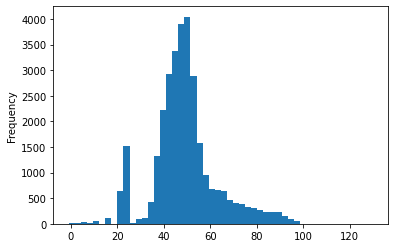

In [ ]:
train["tm"].plot(kind='hist',bins=50)

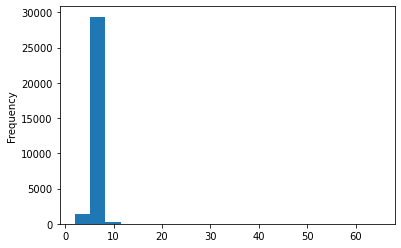

In [ ]:
train["pH"].plot(kind='hist',bins=20)

In [ ]:
train.describe()

,seq_id,pH,tm
count,31390.000000,31104.000000,31390.000000
mean,15694.500000,6.892339,49.147337
std,9061.656811,1.612225,14.010089
min,0.000000,1.990000,-1.000000
25%,7847.250000,7.000000,42.100000
50%,15694.500000,7.000000,48.000000
75%,23541.750000,7.000000,53.800000
max,31389.000000,64.900000,130.000000


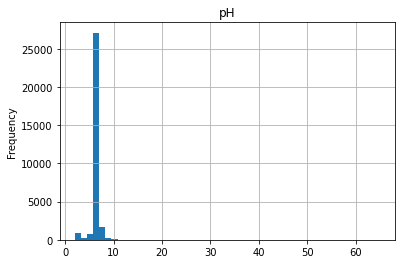

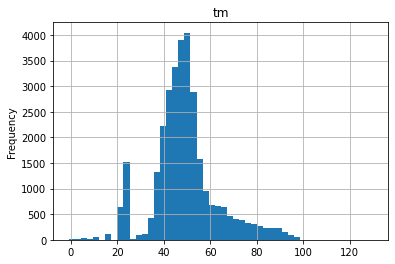

In [ ]:
numerical = ['pH', 'tm']
%matplotlib inline
import matplotlib.pyplot as plt

for col in numerical:
    if pd.api.types.is_numeric_dtype(train[col]) == True:
        train[col].plot.hist(bins=50, grid=True, legend=None)
        plt.title(col)
        plt.show()

Observation: The pH data is skewed to the right. We will remove the outlier (e.g. top X% quantile) and analyze the distribution again.

In [ ]:
pH = train.pH
print('Shape of the pH temp dataset {}'.format(pH.shape))


Shape of the pH temp dataset (31390,)


#Remove Outliers By Percentile Analysis

In [ ]:
# Get the X% percentile of the pH to remove outlier and plot the distribution again 
pH_01 = pH.quantile(0.01)
pH_05 = pH.quantile(0.05)
pH_95 = pH.quantile(0.95)
pH_99 = pH.quantile(0.99)
print('p01 = {}, p05 = {}'.format(pH_01, pH_05))
print('p95 = {}, p99 = {}'.format(pH_95, pH_99))


p01 = 2.7, p05 = 5.4
p95 = 7.5, p99 = 8.2


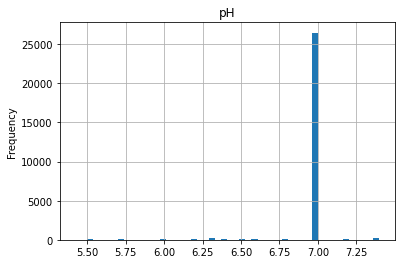

In [ ]:
train[(train['pH']<pH_95) & (train['pH']>pH_05)]['pH'].plot.hist(bins=50, grid=True, legend=None)
plt.title('pH')
plt.show()

Observation: after setting the cap and floor for pH feature, we can see that most pH values are closed to 7


In [ ]:
train['data_source'].value_counts()


doi.org/10.1038/s41592-020-0801-4    24525
10.1021/acscatal.9b05223               211
10.1016/j.bpc.2006.10.014              185
10.7554/eLife.54639                    151
10.1007/s00253-018-8872-1               84
                                     ...  
10.1074/jbc.M001132200                   1
10.1021/bi9530090                        1
10.1016/j.ijbiomac.2008.12.016           1
10.1016/j.jmb.2004.02.073                1
10.1021/bi00219a037                      1
Name: data_source, Length: 324, dtype: int64

Observation: data_source has no irrelevant to the target label.


#Feature engineering


In [ ]:
# Now, we analyze if 1-letter sequence code is representative. E.g. we know that  L, A, V and G are popular sequence code 
Protein_Seq = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Null_Seq = []

for col in Protein_Seq:
    if train['protein_sequence'].str.contains(col).sum() == 0 :
        print('{}: {}'.format(col, train['protein_sequence'].str.contains(col).sum()))
        Null_Seq.append(col)
        
print('Sequence with no occurence : {}'.format(Null_Seq))    


B: 0
J: 0
O: 0
U: 0
X: 0
Z: 0
Sequence with no occurence : ['B', 'J', 'O', 'U', 'X', 'Z']


Observation: Code sequence of B, J, O, U, X and Z are not representative.


In [ ]:
# We only include non-zero 1-letter sequence code in the feature extraction
Letter_1_Seq = []

for i in Protein_Seq:
    if i not in Null_Seq:
        Letter_1_Seq.append(i)

print('1-letter Protein Sequence : {}'.format(Letter_1_Seq))

print('Size of training and testing dataset before extracting 1-letter sequence: {} and {}'.format(train.shape, test.shape))

for col in Letter_1_Seq:
#     print('{}: {}'.format(col, df_train['protein_sequence'].str.contains(col).sum()))
    train[col] = train['protein_sequence'].str.count(col)
    test[col] = test['protein_sequence'].str.count(col)
    
print('Size of training and testing dataset after extracting 1-letter sequence: {} and {}'.format(train.shape, test.shape))


1-letter Protein Sequence : ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
Size of training and testing dataset before extracting 1-letter sequence: (31390, 25) and (2413, 24)
Size of training and testing dataset after extracting 1-letter sequence: (31390, 25) and (2413, 24)


In [ ]:
Letter_Set = Letter_1_Seq

Standardization for numerical labels


In [ ]:
standardScaler = StandardScaler()
encoder_num = standardScaler.fit_transform(train[Letter_Set])
encoded_num = pd.DataFrame(encoder_num, columns =Letter_Set)
print(encoded_num.shape)
print(encoded_num.head(5))

(31390, 20)
          A         C         D         E         F         G         H  \
0  0.244496 -0.439194 -0.336847 -0.045082 -0.179808  0.198720 -0.540171   
1 -0.143868 -0.517543 -0.421907  0.336342 -0.531209 -0.294110 -0.463664   
2  0.358721  0.187599  0.060101 -0.010407  0.221794  0.864041  0.071886   
3 -0.326628 -0.125798 -0.166726 -0.062420 -0.230008 -0.343393 -0.234143   
4  1.181140  0.579344  1.506126  0.787116  0.773996  1.332230  2.290593   

          I         K         L         M         N         P         Q  \
0 -0.266988 -0.243011 -0.095033 -0.206285 -0.550394 -0.100751 -0.467290   
1 -0.294322 -0.183255 -0.362918 -0.743014 -0.510646 -0.323040  0.089106   
2 -0.212321  0.215114 -0.458592 -0.385195 -0.152912 -0.056293  0.193430   
3 -0.376323 -0.223092 -0.267245 -0.743014 -0.391401 -0.145209 -0.362966   
4  1.291032  0.792749  1.186989  1.851177  1.834498  2.344428  1.201898   

          R         S         T         V         W         Y  
0  0.037342 -0.420282 

#Model - XGBooster


In [ ]:
from sklearn.model_selection import train_test_split
import xgboost

In [ ]:

X = encoded_num.copy()
y = train['tm']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Hyperparameter for XGBoost

In [ ]:
#XGBoost hyper-parameter tuning
def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [10, 15, 20, 25],
        'min_child_weight': [5, 10, 20, 30],
        'subsample': [0.3, 0.5, 0.7],
        'colsample_bytree': [0.3, 0.5, 0.7],
        'n_estimators' : [500], # , 500, 750, 1000
        'objective': ['reg:squarederror']
    }

    xgb_model = xgboost.XGBRegressor()

    gsearch = RandomizedSearchCV(estimator = xgb_model,
                           param_distributions = param_tuning,                        
                           cv = 3,
                           n_iter=35, 
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [ ]:
#Run only in the first run of the kernel.
#best_model = hyperParameterTuning(X_train, y_train)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


In [ ]:
#print(best_model)

{'subsample': 0.7, 'objective': 'reg:squarederror', 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 25, 'learning_rate': 0.01, 'colsample_bytree': 0.7}


In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
#xgb_model_best = xgboost.XGBRegressor(**best_model)
#%time model_xbg.fit(X_train, y_train,early_stopping_rounds=5000, verbose=250)

In [ ]:
# best fit
model_XGBoost = xgboost.XGBRegressor(n_estimators=500, max_depth=10, learning_rate= 0.001)
# model = xgboost.XGBRegressor()

model_XGBoost.fit(X_train, y_train)

print('Model model_XGBoost Training is done!')

[04:43:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Model model_XGBoost Training is done!


In [ ]:
y_pred_xgb = model_XGBoost.predict(X_test)

#Spearman's rank correlation coefficient

In [ ]:
from scipy import stats

print(stats.spearmanr(y_test, y_pred_xgb))

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print("MAE: ", mae_xgb)


SpearmanrResult(correlation=0.47687532886373235, pvalue=0.0)
MAE:  29.76937367159862


#Prediction

In [ ]:
submission = pd.DataFrame()

submission['seq_id'] = test['seq_id']

encoded_num = standardScaler.transform(test[Letter_Set])

df_pred = pd.DataFrame(encoded_num, columns =Letter_Set)

submission['tm'] = model_XGBoost.predict(df_pred)

print(submission.head(10))

submission.to_csv("submission.csv", index=False)
print('Submission Done')


   seq_id         tm
0   31390  19.464001
1   31391  19.464001
2   31392  19.464001
3   31393  19.584177
4   31394  19.584177
5   31395  19.584177
6   31396  19.584177
7   31397  19.584177
8   31398  19.464001
9   31399  19.464001
Submission Done
